## Life history traits model  

a50 and s only models for model comparison

model 6: fixed effect a50 covariates only  
model 7: fixed effect s covariates only  
model 8: mixed effect a50 covariates only  
model 9: mixed effect s covariates only  

### Set up notebook

In [1]:
#import packages
import datetime 
from itertools import product
import logging
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import os
from math import isnan
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import seaborn as sns
import pymc3 as pm  
from theano import tensor as tt
from theano import shared
import arviz as az
import warnings

%matplotlib inline  
#%matplotlib inline is a magic function that renders the figure in a notebook (instead of displaying a dump of the figure object)
from matplotlib import pyplot as plt 
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import FuncFormatter, StrMethodFormatter


In [2]:
# Aaron Helper function
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: [ b.index(x) if x in b else None for x in a ]
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdise(x):
    return (x-np.mean(x))/(np.std(x)*2)

def invlogit(x):
    return np.exp(x)/(1+np.exp(x))

def gelplot(pj,vector,posy,csize=40,lwd50=7,lwd95=1):
    if np.percentile(vector,2.5)<0 and 0<np.percentile(vector,97.5):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='grey')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='grey')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='grey')
    else:
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='black')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='black')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='black')
        
    if np.percentile(vector,25)<0 and 0<np.percentile(vector,75):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='white')

In [3]:
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Data\\for model\\in')
os.listdir() # list files in directory

['age_structured_traits.xlsx',
 'car_trait_covariates_v2.xlsx',
 'full_dataset.xlsx',
 'species_level_traits_v1.xlsx',
 '~$car_trait_covariates_v2.xlsx',
 '~$full_dataset.xlsx']

### Import and structure data

In [4]:
# Import full dataset
data = pd.read_excel('full_dataset.xlsx')
#get rid of species that don't have full complement of trait data
data = data[data.param_complete==0]
data.head()

Species     Stock   Stock_Year  Age  maturity survivorship  \
0  Carcharhinus tilstoni  ABTP-SWP  ABTP-SWP-13    0  0.000000          NaN   
1  Carcharhinus tilstoni  ABTP-SWP  ABTP-SWP-13    1  0.000000          NaN   
2  Carcharhinus tilstoni  ABTP-SWP  ABTP-SWP-13    2  0.000000          NaN   
3  Carcharhinus tilstoni  ABTP-SWP  ABTP-SWP-13    3  0.000000          NaN   
4  Carcharhinus tilstoni  ABTP-SWP  ABTP-SWP-13    4  0.016088          NaN   

   fecundity (num female pups per year) notes model type  source_mat  ...  \
0                                   NaN   NaN        NaN  Harry 2013  ...   
1                                   NaN   NaN        NaN  Harry 2013  ...   
2                                   NaN   NaN        NaN  Harry 2013  ...   
3                                   NaN   NaN        NaN  Harry 2013  ...   
4                                   NaN   NaN        NaN  Harry 2013  ...   

  age_50_maturity length_maturity_cm linf_cm growth_coeff_k lmax_cm  \
0             6.1              125.0   218.0          0.089   166.0   
1             6.1              125.0   218.0          0.089   166.0   
2             6.1              125.0   218.0          0.089   166.0   
3             6.1              125.0   218.0          0.089   166.0   
4             6.1              125.0   218.0          0.089   166.0   

   age_max_yrs temp_pref nursery depth_ave param_complete  
0         15.0       0.0     0.0      75.0            0.0  
1         15.0       0.0     0.0      75.0            0.0  
2         15.0       0.0     0.0      75.0            0.0  
3         15.0       0.0     0.0      75.0            0.0  
4         15.0       0.0     0.0      75.0            0.0  

[5 rows x 35 columns]

In [5]:
# Add  offspring size and  litter size relative to length at maturity
data['relative_litter_size'] = data.litter_size/data.length_maturity_cm
data['relative_offspring_size'] = (data.offspring_size_mm/10)/data.length_maturity_cm

In [6]:
#list columns
data.columns

Index(['Species', 'Stock', 'Stock_Year', 'Age', 'maturity', 'survivorship',
       'fecundity (num female pups per year)', 'notes', 'model type',
       'source_mat', 'source_sur', 'source_fec', 'source_m_link',
       'source_s_link', 'source_f_link', 'Cortes_2018', 'SA_mat', 'SA_sur',
       'SA_fec', 'FP_species', 'habitat', 'trophic_level', 'offspring_size_mm',
       'litter_size', 'interbirth_interval_yrs', 'age_50_maturity',
       'length_maturity_cm', 'linf_cm', 'growth_coeff_k', 'lmax_cm',
       'age_max_yrs', 'temp_pref', 'nursery', 'depth_ave', 'param_complete',
       'relative_litter_size', 'relative_offspring_size'],
      dtype='object')

In [7]:
# make datafame of only stocks which have age-structured maturity data
# only data rows where SA-mat A
mdata= data[data.SA_mat=='A']
mdata.shape

(505, 37)

## Format data

In [10]:
# Make arrays of response variables
AGE = mdata.Age.values
nobs = len(AGE)
MAT = mdata.maturity.values

In [11]:
# Make an index for stock-years 
# Puts an index value unique to the stock year for each row in df
StockYr, Is = indexall(mdata.Stock_Year.values)
nstocks = len(StockYr)
StockYr

['ABTP-SWP-13',
 'ATSH-GOM-03',
 'ATSH-NWA-07',
 'ATSH-NWA-13',
 'BNOS-GOM-11',
 'BNOS-NWA-07',
 'BNOS-NWA-11',
 'BTIP-GOM-05',
 'BTIP-GOM-12',
 'BTIP-NWA-06',
 'COP-SWA-03',
 'DUS-NWA-06',
 'DUS-NWA-11',
 'FTH-GOM-03',
 'FTH-NWA-07',
 'GRE-SWP-06',
 'NER-I-02',
 'OCW-WCP-12',
 'SAN-NWA-06',
 'SAN-NWA-11',
 'SPIN-WP-05',
 'SPT-SWP-13',
 'WTIP-SWP-06']

In [12]:
#Index of covariates
Sind = np.array([list(mdata.Stock_Year.values).index(S) for S in StockYr])

#make arrays of all the covariates
#put Sind after all of these so they match the length of StockYr
LMAX = mdata.lmax_cm.values[Sind]
HAB = mdata.habitat.values[Sind]
TROPH = mdata.trophic_level.values[Sind]
OFFSZ = mdata.offspring_size_mm.values[Sind]
ROFFSZ = mdata.relative_offspring_size.values[Sind]
LITT = mdata.litter_size.values[Sind]
RLITT = mdata.relative_litter_size.values[Sind]
INTR = mdata.interbirth_interval_yrs.values[Sind]
AMAT = mdata.age_50_maturity.values[Sind]
LMAT = mdata.length_maturity_cm.values[Sind]
LINF = mdata.linf_cm.values[Sind]
K = mdata.growth_coeff_k.values[Sind]
AMAX = mdata.age_max_yrs.values[Sind]
DEP = mdata.depth_ave.values[Sind]

In [13]:
# standardise continuous covariates
LMAX = stdise(LMAX)
TROPH = stdise(TROPH)
OFFSZ = stdise(OFFSZ)
ROFFSZ = stdise(ROFFSZ)
LITT = stdise(LITT)
RLITT = stdise(RLITT)
INTR = stdise(INTR)
LMAT = stdise(LMAT)
LINF = stdise(LINF)
K = stdise(K)
AMAX = stdise(AMAX)
DEP = stdise(DEP)
#need to transform habitat somehow?

# Bayes model

Maturity model has 2 parts to assess the 2 parameters which describe the maturity curve

$$m = \frac{1}{1+e^{-S}(a-a_{50})}$$


a50 null model:
$$
\small{
a_{50} \sim Normal(Ga_{50},\sigma a_{50}) \\ 
Ga_{50} \sim Uniform(1.5, 25)  \\
\sigma a_{50} \sim Exponential(0.5) 
}
$$



S null model:
$$
\small{
S \sim Normal(GS,\sigma S) \\
GS \sim Uniform(0.01, 10)  \\
\sigma S \sim Exponential(1) 
}
$$

### Fixed effects models

In [22]:
# Model 6
# fixed effect model with a50 covariates only
# Using relative litter size and offspring size 
with pm.Model() as mat6:
    
    # Hierarchical a50
    Ga50 = pm.Uniform('Ga50', 1.5, 25) #mean a50 has uniform distribution from 1.5 to 25
    #a50_sigma = pm.Exponential('a50_sigma', 0.5) #std dev of a50 is exponential distribution with lambda of 0.5
    #a50 = pm.Normal('a50x', Ga50, a50_sigma) #likelihood of a50 values given distributions of Ga50 and sigma_a50 (I think... what is shape for?)
    # set up priors for slope values between a50 and covariates
    # first argument is just a name not an actual dataset - doesn't need to match name of data array
    β1 = pm.Normal('Lmax', 0, 3) 
   # β2 = pm.Normal('Linf', 0, 3)
    β3 = pm.Normal('Depth', 0, 3)
    β4 = pm.Normal('K', 0, 3)
   # β5 = pm.Normal ('Habitat', 0, 3) # How to set this up for a categorical variable?
    β6 = pm.Normal('Interbirth_interval', 0, 3)
    β7 = pm.Normal('Amax', 0, 3)
    β8 = pm.Normal('Litter', 0, 3)
    β9 = pm.Normal('Offspring_size', 0, 3)
    β10 = pm.Normal('Trophic', 0, 3)
 #   β11 = pm.Normal('Lmat', 0, 3)
    
    # Hierarchical S
    # S is the curve parameter determining steepness/shape of maturity curve
    # GS is mean of distribution describing what S is
    # S_sigma is standard dev of distribution around GS
     
    GS = pm.Uniform('GS', 0.01, 10) # Uniform distribution of possible S values from 0.01 to 10
    #S_sigma = pm.Exponential('S_sigma', 1) #Exponential distribution of possible sigma values with lambda of 1
    #S = pm.Normal('Sx', GS, S_sigma, shape=nstocks) 
    
    # a50 model
    # put all parameters that influence a50 here (all the β params from above)
    mu_a50 = pm.Deterministic("mu_a50", Ga50 + β1*LMAX + β3*DEP + β4*K + β6*INTR + β7*AMAX + β8*RLITT + β9*ROFFSZ + β10*TROPH)
 
    # Growth (S) model
    #put all parameters that influence S here 
    mu_S = pm.Deterministic("mu_S", GS)
    
    # Growth model
    mu = 1/(1+tt.exp(-mu_S*(AGE-mu_a50[Is])))

    # tt=under the hood modelling stuff - tensor flow package. makes exp work
    # Is is index values of stock codes

    # Likelihood
    S2 = pm.Uniform('S2', 0.0, 0.1) 
    Yi = pm.Normal('Yi', mu, S2, observed=MAT)
    

In [25]:
# Sampling
with mat6:
    trace6 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [S2, GS, Trophic, Offspring_size, Litter, Amax, Interbirth_interval, K, Depth, Lmax, Ga50]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 781 seconds.


C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000268C158C588>,
      dtype=object)

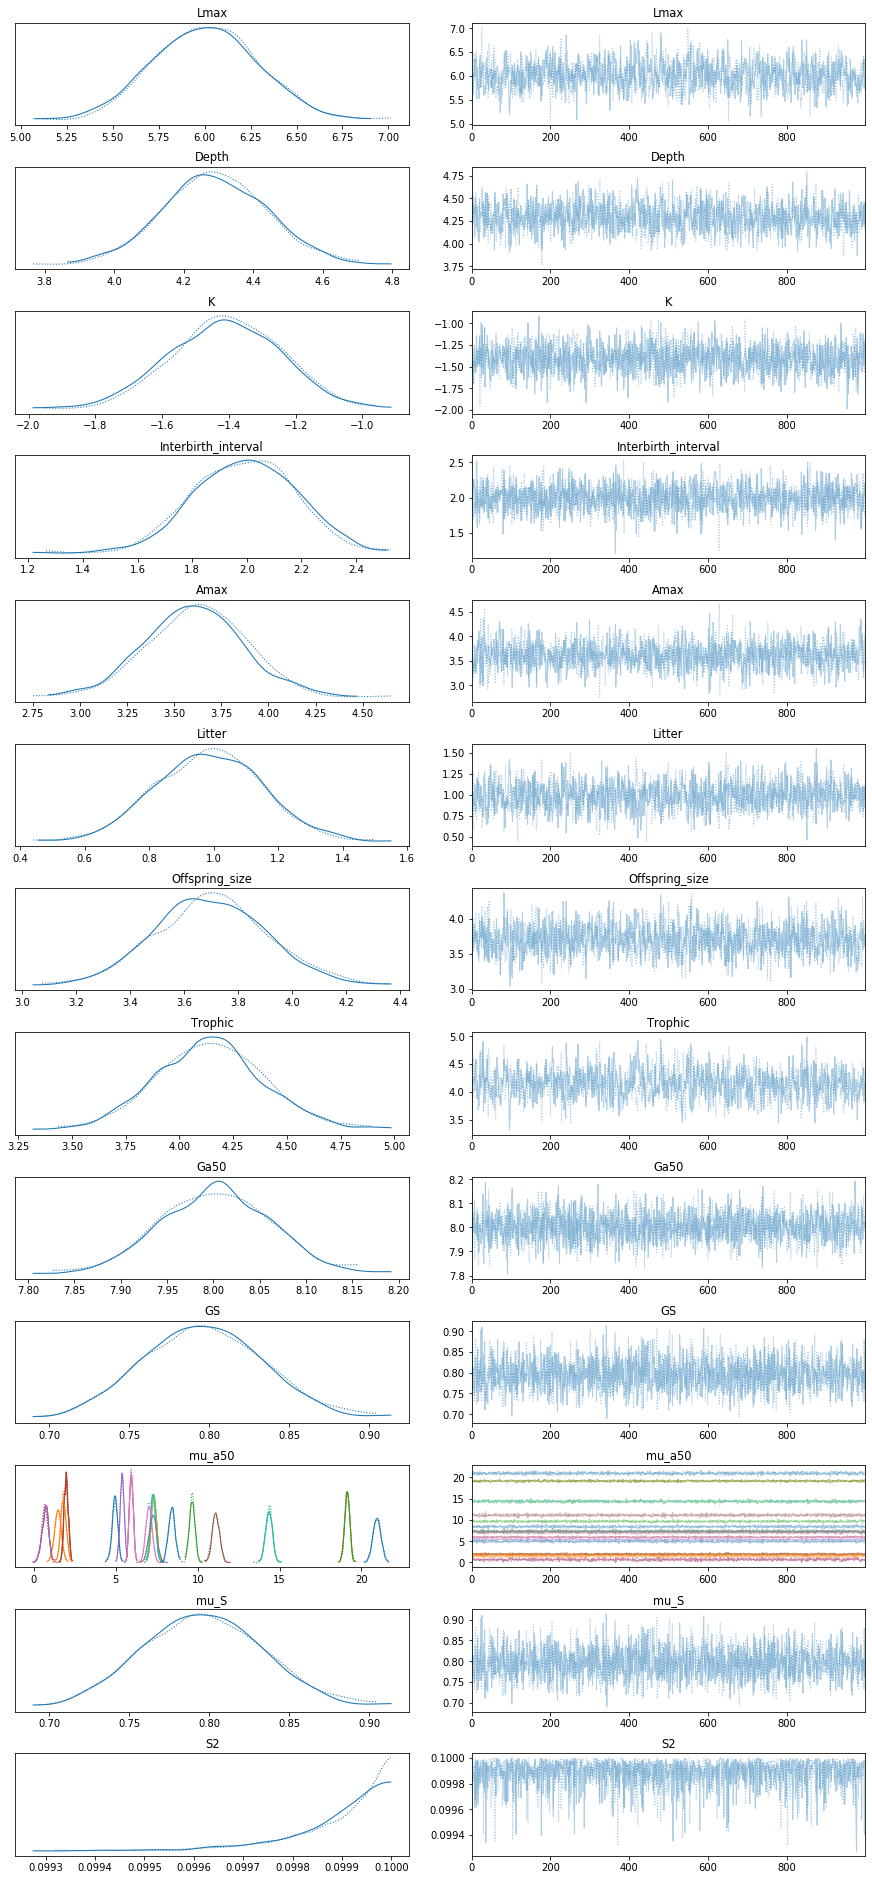

In [26]:
pm.traceplot(trace6)

In [30]:
pm.summary(trace6)

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Lmax                  6.010  0.285   5.472    6.518      0.009    0.007   
Depth                 4.290  0.147   4.011    4.574      0.004    0.003   
K                    -1.408  0.162  -1.718   -1.126      0.004    0.003   
Interbirth_interval   1.993  0.185   1.673    2.349      0.004    0.003   
Amax                  3.614  0.263   3.163    4.146      0.007    0.005   
Litter                0.985  0.164   0.693    1.303      0.005    0.003   
Offspring_size        3.701  0.209   3.326    4.116      0.007    0.005   
Trophic               4.144  0.252   3.647    4.591      0.009    0.006   
Ga50                  8.003  0.060   7.886    8.106      0.001    0.001   
GS                    0.797  0.037   0.728    0.866      0.001    0.001   
mu_a50[0]             4.941  0.168   4.613    5.240      0.004    0.003   
mu_a50[1]             1.461  0.206   1.082    1.871      0.005    0.003   
mu_a50[2]             1.965  0.128   1.706    2.185      0.003    0.002   
mu_a50[3]             1.965  0.128   1.706    2.185      0.003    0.002   
mu_a50[4]             5.385  0.123   5.132    5.605      0.003    0.002   
mu_a50[5]             5.942  0.117   5.733    6.168      0.003    0.002   
mu_a50[6]             5.942  0.117   5.733    6.168      0.003    0.002   
mu_a50[7]             7.322  0.161   7.005    7.600      0.005    0.003   
mu_a50[8]             7.322  0.161   7.005    7.600      0.005    0.003   
mu_a50[9]             7.270  0.161   6.954    7.549      0.005    0.003   
mu_a50[10]           20.951  0.242  20.502   21.414      0.005    0.004   
mu_a50[11]           19.132  0.154  18.859   19.440      0.003    0.002   
mu_a50[12]           19.132  0.154  18.859   19.440      0.003    0.002   
mu_a50[13]            0.679  0.197   0.288    1.024      0.006    0.004   
mu_a50[14]            0.679  0.197   0.288    1.024      0.006    0.004   
mu_a50[15]           11.107  0.222  10.699   11.519      0.004    0.003   
mu_a50[16]            7.022  0.190   6.680    7.390      0.005    0.004   
mu_a50[17]            7.258  0.229   6.809    7.665      0.006    0.005   
mu_a50[18]           14.353  0.207  13.962   14.727      0.004    0.003   
mu_a50[19]           14.353  0.207  13.962   14.727      0.004    0.003   
mu_a50[20]            8.414  0.199   8.035    8.776      0.005    0.004   
mu_a50[21]            1.804  0.168   1.483    2.106      0.004    0.003   
mu_a50[22]            9.660  0.168   9.319    9.938      0.003    0.002   
mu_S                  0.797  0.037   0.728    0.866      0.001    0.001   
S2                    0.100  0.000   0.100    0.100      0.000    0.000   

                     ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
Lmax                    910.0   910.0     911.0    1282.0    1.0  
Depth                  1099.0  1095.0    1103.0    1330.0    1.0  
K                      1833.0  1758.0    1849.0    1546.0    1.0  
Interbirth_interval    1911.0  1911.0    1983.0    1519.0    1.0  
Amax                   1528.0  1514.0    1522.0    1317.0    1.0  
Litter                 1129.0  1129.0    1131.0    1380.0    1.0  
Offspring_size          999.0   996.0    1004.0    1066.0    1.0  
Trophic                 819.0   816.0     822.0     972.0    1.0  
Ga50                   1977.0  1973.0    1971.0    1575.0    1.0  
GS                     2086.0  2082.0    2093.0    1529.0    1.0  
mu_a50[0]              1922.0  1921.0    1954.0    1523.0    1.0  
mu_a50[1]              2081.0  2081.0    2083.0    1569.0    1.0  
mu_a50[2]              2100.0  2100.0    2087.0    1599.0    1.0  
mu_a50[3]              2100.0  2100.0    2087.0    1599.0    1.0  
mu_a50[4]              1750.0  1746.0    1764.0    1465.0    1.0  
mu_a50[5]              1389.0  1386.0    1393.0    1728.0    1.0  
mu_a50[6]              1389.0  1386.0    1393.0    1728.0    1.0  
mu_a50[7]              1268.0  1268.0    1262.0    1297.0    1.0  
mu_a50[8]              1268.0  1268.0    1262.0  

In [44]:
# Model 7
# fixed effect model with s covariates only
# Using relative litter size and offspring size 
with pm.Model() as mat7:
    
    # Hierarchical a50
    Ga50 = pm.Uniform('Ga50', 1.5, 25) #mean a50 has uniform distribution from 1.5 to 25
    #a50_sigma = pm.Exponential('a50_sigma', 0.5) #std dev of a50 is exponential distribution with lambda of 0.5
    #a50 = pm.Normal('a50x', Ga50, a50_sigma) #likelihood of a50 values given distributions of Ga50 and sigma_a50 (I think... what is shape for?)
    
    # Hierarchical S
    # S is the curve parameter determining steepness/shape of maturity curve 
    GS = pm.Uniform('GS', 0.01, 10) # Uniform distribution of possible S values from 0.01 to 10
    
    # now put all the priors for covariates of S
    B1 = pm.Normal('Lmax-S', 0, 3)
    B3 = pm.Normal('Depth-S', 0, 3)
    B4 = pm.Normal('K-S', 0, 3)
   # β5 = pm.Normal ('Habitat', 0, 3) # How to set this up for a categorical variable?
    B6 = pm.Normal('Interbirth_interval-S', 0, 3)
    B7 = pm.Normal('Amax-S', 0, 3)
    B8 = pm.Normal('Litter-S', 0, 3)
    B9 = pm.Normal('Offspring_size-S', 0, 3)
    B10 = pm.Normal('Trophic-S', 0, 3)
 #   B11 = pm.Normal('Lmat-S', 0, 3)
    
    # a50 model
    # put all parameters that influence a50 here (all the β params from above)
    mu_a50 = pm.Deterministic("mu_a50", Ga50)
 
    # Growth (S) model
    #put all parameters that influence S here 
    mu_S = pm.Deterministic("mu_S", GS + B1*LMAX + B3*DEP + B4*K + B6*INTR + B7*AMAX + B8*RLITT + B9*ROFFSZ + B10*TROPH)
    
    # Growth model
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-a50[Is])))
    mu = 1/(1+tt.exp(-mu_S[Is]*(AGE-mu_a50)))

    # tt=under the hood modelling stuff - tensor flow package. makes exp work
    # Is is index values of stock codes

    # Likelihood
    S2 = pm.Uniform('S2', 0.0, 0.1) 
    Yi = pm.Normal('Yi', mu, S2, observed=MAT)
    

In [45]:
with mat7:
    trace7=pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [S2, Trophic-S, Offspring_size-S, Litter-S, Amax-S, Interbirth_interval-S, K-S, Depth-S, Lmax-S, GS, Ga50]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2196 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


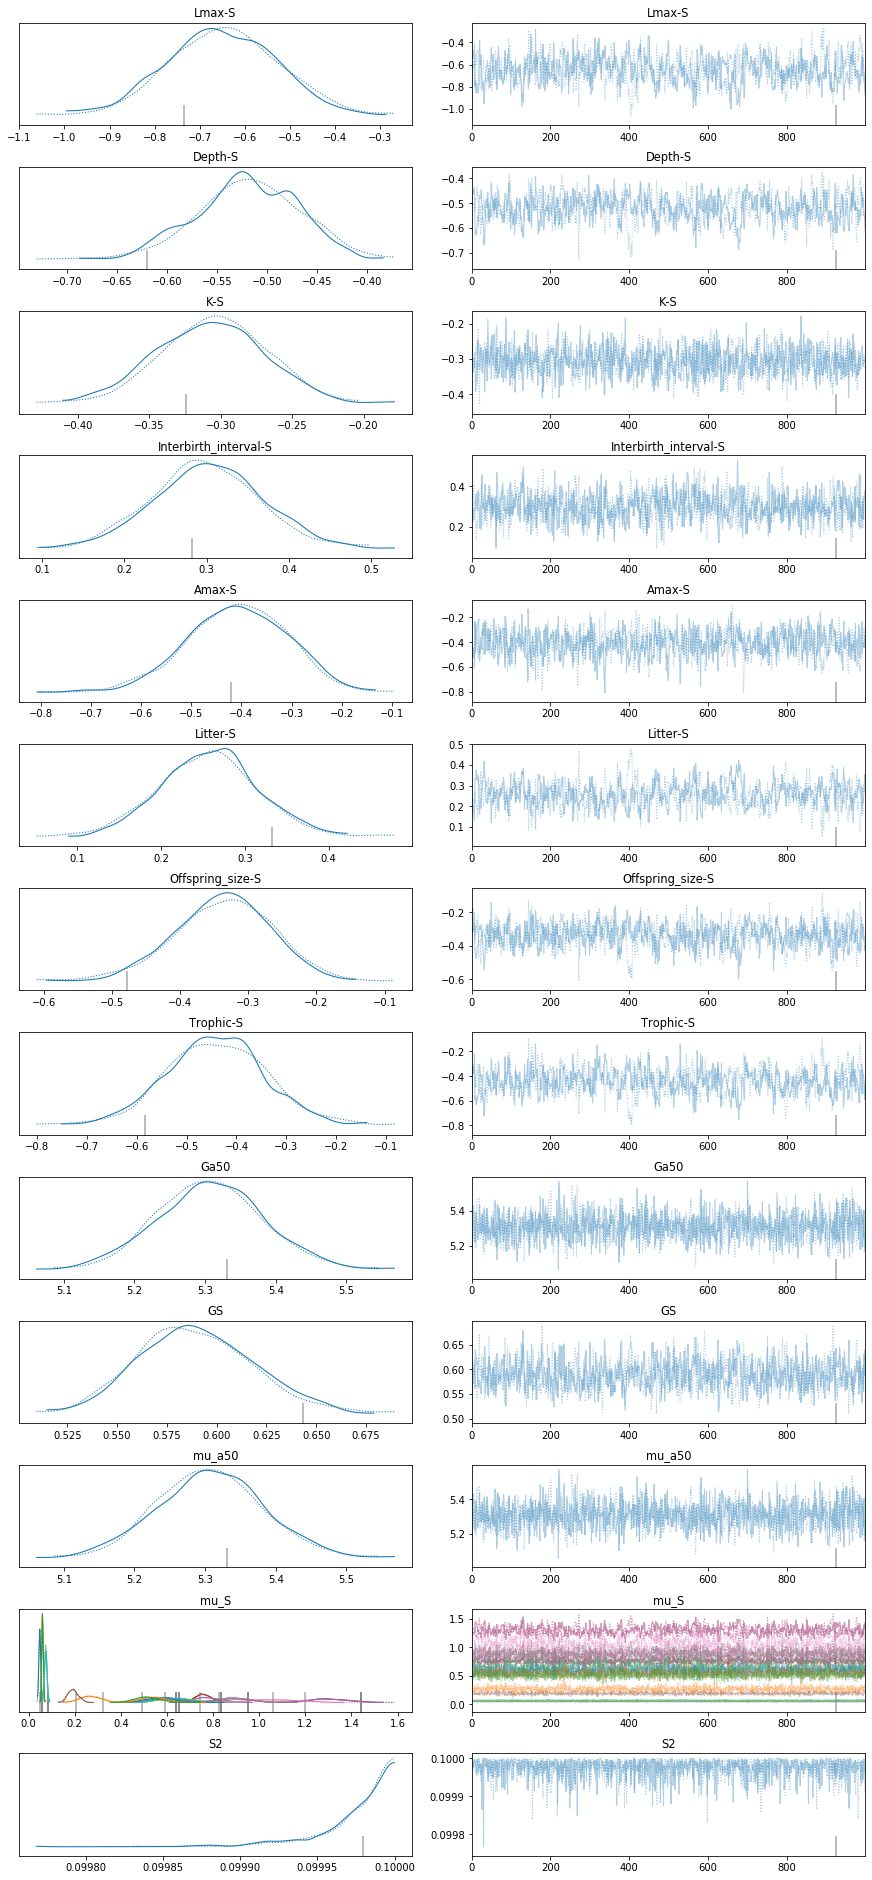

In [46]:
#check model performance
pm.traceplot(trace7);

In [47]:
pm.summary(trace7)
# looking for r-hat values of 1 - shows that model is converging

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Lmax-S                -0.649  0.122  -0.861   -0.413      0.006    0.005   
Depth-S               -0.520  0.052  -0.618   -0.424      0.003    0.002   
K-S                   -0.306  0.038  -0.379   -0.237      0.001    0.001   
Interbirth_interval-S  0.300  0.065   0.179    0.423      0.002    0.002   
Amax-S                -0.409  0.101  -0.608   -0.238      0.004    0.003   
Litter-S               0.257  0.059   0.142    0.364      0.003    0.002   
Offspring_size-S      -0.337  0.072  -0.468   -0.201      0.004    0.003   
Trophic-S             -0.442  0.100  -0.620   -0.238      0.005    0.004   
Ga50                   5.308  0.075   5.175    5.457      0.002    0.001   
GS                     0.590  0.029   0.535    0.641      0.001    0.001   
mu_a50                 5.308  0.075   5.175    5.457      0.002    0.001   
mu_S[0]                0.600  0.059   0.481    0.703      0.002    0.001   
mu_S[1]                0.270  0.045   0.184    0.349      0.001    0.001   
mu_S[2]                0.758  0.036   0.696    0.829      0.001    0.001   
mu_S[3]                0.758  0.036   0.696    0.829      0.001    0.001   
mu_S[4]                0.774  0.058   0.672    0.888      0.002    0.002   
mu_S[5]                0.895  0.062   0.790    1.017      0.003    0.002   
mu_S[6]                0.895  0.062   0.790    1.017      0.003    0.002   
mu_S[7]                0.642  0.070   0.518    0.772      0.003    0.002   
mu_S[8]                0.642  0.070   0.518    0.772      0.003    0.002   
mu_S[9]                0.631  0.070   0.509    0.761      0.003    0.002   
mu_S[10]               0.048  0.004   0.040    0.055      0.000    0.000   
mu_S[11]               0.060  0.003   0.054    0.066      0.000    0.000   
mu_S[12]               0.060  0.003   0.054    0.066      0.000    0.000   
mu_S[13]               1.300  0.080   1.154    1.446      0.003    0.002   
mu_S[14]               1.300  0.080   1.154    1.446      0.003    0.002   
mu_S[15]               0.193  0.022   0.154    0.236      0.000    0.000   
mu_S[16]               1.067  0.102   0.890    1.260      0.005    0.003   
mu_S[17]               0.886  0.079   0.740    1.035      0.003    0.002   
mu_S[18]               0.074  0.005   0.064    0.084      0.000    0.000   
mu_S[19]               0.074  0.005   0.064    0.084      0.000    0.000   
mu_S[20]               0.574  0.067   0.457    0.705      0.002    0.002   
mu_S[21]               0.543  0.055   0.429    0.636      0.001    0.001   
mu_S[22]               0.514  0.055   0.405    0.610      0.001    0.001   
S2                     0.100  0.000   0.100    0.100      0.000    0.000   

                       ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
Lmax-S                    382.0   356.0     384.0     414.0   1.01  
Depth-S                   368.0   356.0     379.0     435.0   1.00  
K-S                      1014.0   996.0    1018.0    1150.0   1.00  
Interbirth_interval-S     812.0   783.0     809.0    1033.0   1.00  
Amax-S                    694.0   671.0     709.0     882.0   1.01  
Litter-S                  339.0   314.0     344.0     364.0   1.01  
Offspring_size-S          406.0   381.0     420.0     396.0   1.00  
Trophic-S                 365.0   343.0     368.0     388.0   1.01  
Ga50                     1575.0  1574.0    1573.0    1180.0   1.00  
GS                        760.0   758.0     769.0    1019.0   1.00  
mu_a50                   1575.0  1574.0    1573.0    1180.0   1.00  
mu_S[0]                  1141.0  1141.0    1121.0    1471.0   1.00  
mu_S[1]                  1850.0  1806.0    1850.0    1452.0   1.00  
mu_S[2]                   802.0   799.0     809.0    1188.0   1.00  
mu_S[3]                   802.0   799.0     809.0    1188.0   1.00  
mu_S[4]                   568.0   555.0     583.0     886.0   1.00  
mu_S[5]                   546.0   534.0     561.0     879.0   1.00  
mu_S[6]                   546.0   534.0     5

### Mixed effects models

In [37]:
# Model 8
# mixed effects model with covariates only for a50
# Note that this model uses relative litter and relative offspring size rather than absolute values
with pm.Model() as mat8:
    
    # Hierarchical a50
    Ga50 = pm.Uniform('Ga50', 1.5, 25) #mean a50 has uniform distribution from 1.5 to 25
    a50_sigma = pm.Exponential('a50_sigma', 0.5) #std dev of a50 is exponential distribution with lambda of 0.5
    a50 = pm.Normal('a50x', Ga50, a50_sigma, shape=nstocks) #likelihood of a50 values given distributions of Ga50 and sigma_a50 (I think... what is shape for?)
    # set up priors for slope values between a50 and covariates
    # first argument is just a name not an actual dataset - doesn't need to match name of data array
    β1 = pm.Normal('Lmax', 0, 3) 
   # β2 = pm.Normal('Linf', 0, 3) # don't use Linf bc same thing as Lmax, also effect too similar to K
    β3 = pm.Normal('Depth', 0, 3)
    β4 = pm.Normal('K', 0, 3)
   # β5 = pm.Normal ('Habitat', 0, 3) # How to set this up for a categorical variable?
    β6 = pm.Normal('Interbirth_interval', 0, 3)
    β7 = pm.Normal('Amax', 0, 3)
    β8 = pm.Normal('Litter', 0, 3)
    β9 = pm.Normal('Offspring_size', 0, 3)
    β10 = pm.Normal('Trophic', 0, 3)
  #  β11 = pm.Normal('Lmat', 0, 3)  # Don't use Lmat because same thing as a50

    
    # Hierarchical S
    # S is the curve parameter determining steepness/shape of maturity curve
    # GS is mean of distribution describing what S is
    # S_sigma is standard dev of distribution around GS
    GS = pm.Uniform('GS', 0.01, 10) # Uniform distribution of possible S values from 0.01 to 10
    S_sigma = pm.Exponential('S_sigma', 1) #Exponential distribution of possible sigma values with lambda of 1
    S = pm.Normal('Sx', GS, S_sigma, shape=nstocks) 
    
    # priors for covariates of S

    
    # a50 model
    # put all parameters that influence a50 here (all the β params from above)
    mu_a50 = pm.Deterministic("mu_a50", a50 + β1*LMAX + β3*DEP + β4*K + β6*INTR + β7*AMAX + β8*RLITT + β9*ROFFSZ + β10*TROPH)
    #mu_a50 = pm.Deterministic("mu_a50", a50 + β1*LMAX) #try running model with 1 covariate to test for overfitting
 
    # Growth (S) model
    mu_S = pm.Deterministic("mu_S", S)
    
    # Growth model
    mu = 1/(1+tt.exp(-mu_S[Is]*(AGE-mu_a50[Is])))
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-mu_a50[Is])))
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-a50[Is])))

    # tt=under the hood modelling stuff - tensor flow package. makes exp work
    # Is is index values of stock codes

    # Likelihood
    S2 = pm.Uniform('S2', 0.0, 0.1) #variance for likelihood equation
    Yi = pm.Normal('Yi', mu, S2, observed=MAT)
    

In [33]:
# Sampling
with mat8:
    trace8 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [S2, Sx, S_sigma, GS, Trophic, Offspring_size, Litter, Amax, Interbirth_interval, K, Depth, Lmax, a50x, a50_sigma, Ga50]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 31909 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000268BFCE7F88>,
      dtype=object)

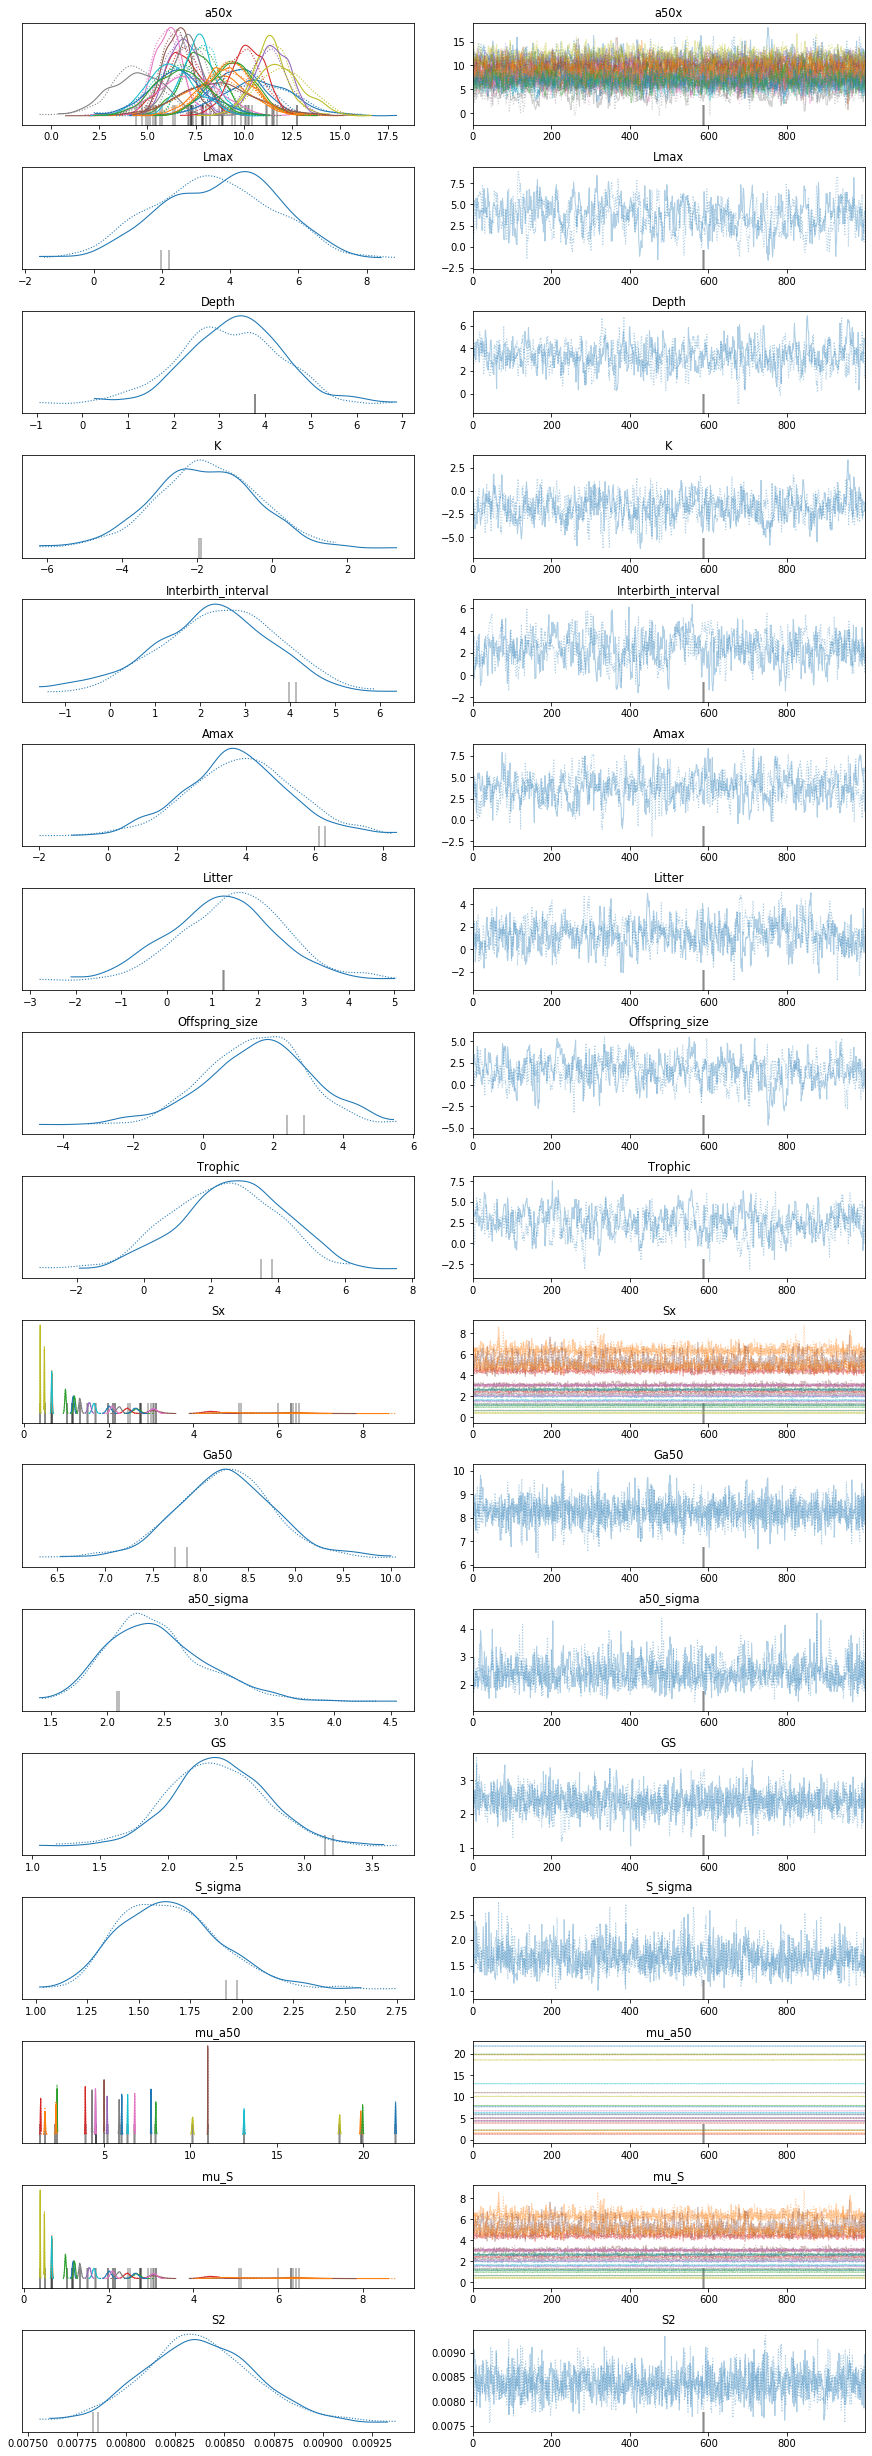

In [38]:
pm.traceplot(trace8)

In [39]:
pm.summary(trace8)

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a50x[0]   9.733  1.378   7.201   12.308      0.088    0.062     247.0   247.0   
a50x[1]   8.567  1.814   4.907   11.735      0.085    0.060     460.0   460.0   
a50x[2]   7.837  1.000   5.759    9.494      0.060    0.042     279.0   279.0   
a50x[3]   6.888  1.000   5.087    8.827      0.060    0.042     279.0   279.0   
a50x[4]   6.748  0.805   5.255    8.158      0.053    0.038     228.0   228.0   
...         ...    ...     ...      ...        ...      ...       ...     ...   
mu_S[19]  0.657  0.010   0.640    0.676      0.000    0.000    1619.0  1618.0   
mu_S[20]  2.631  0.074   2.492    2.764      0.002    0.001    2353.0  2353.0   
mu_S[21]  4.967  0.421   4.289    5.795      0.016    0.012     672.0   638.0   
mu_S[22]  1.196  0.023   1.155    1.240      0.001    0.000    1707.0  1702.0   
S2        0.008  0.000   0.008    0.009      0.000    0.000    1435.0  1428.0   

          ess_bulk  ess_tail  r_hat  
a50x[0]      251.0     552.0   1.02  
a50x[1]      459.0     824.0   1.00  
a50x[2]      280.0     434.0   1.01  
a50x[3]      280.0     417.0   1.01  
a50x[4]      230.0     579.0   1.02  
...            ...       ...    ...  
mu_S[19]    1618.0    1456.0   1.00  
mu_S[20]    2353.0    1486.0   1.00  
mu_S[21]     843.0     685.0   1.00  
mu_S[22]    1721.0    1627.0   1.00  
S2          1440.0    1123.0   1.00  

[105 rows x 11 columns]

In [40]:
# Model 9
# mixed effects model with covariates only for s
with pm.Model() as mat9:
    
    # Hierarchical a50
    Ga50 = pm.Uniform('Ga50', 1.5, 25) #mean a50 has uniform distribution from 1.5 to 25
    a50_sigma = pm.Exponential('a50_sigma', 0.5) #std dev of a50 is exponential distribution with lambda of 0.5
    a50 = pm.Normal('a50x', Ga50, a50_sigma, shape=nstocks) #likelihood of a50 values given distributions of Ga50 and sigma_a50 (I think... what is shape for?)
    # set up priors for slope values between a50 and covariates
    
    # Hierarchical S
    # S is the curve parameter determining steepness/shape of maturity curve
    # GS is mean of distribution describing what S is
    # S_sigma is standard dev of distribution around GS
    GS = pm.Uniform('GS', 0.01, 10) # Uniform distribution of possible S values from 0.01 to 10
    S_sigma = pm.Exponential('S_sigma', 1) #Exponential distribution of possible sigma values with lambda of 1
    S = pm.Normal('Sx', GS, S_sigma, shape=nstocks) 
    
    # priors for covariates of S
    B1 = pm.Normal('Lmax-S', 0, 3)
    B3 = pm.Normal('Depth-S', 0, 3)
    B4 = pm.Normal('K-S', 0, 3)
   # β5 = pm.Normal ('Habitat', 0, 3) # How to set this up for a categorical variable?
    B6 = pm.Normal('Interbirth_interval-S', 0, 3)
    B7 = pm.Normal('Amax-S', 0, 3)
    B8 = pm.Normal('Litter-S', 0, 3)
    B9 = pm.Normal('Offspring_size-S', 0, 3)
    B10 = pm.Normal('Trophic-S', 0, 3)
    # no lmat because treating S and a50 as if they behave separately
    
    
    # a50 model
    # put all parameters that influence a50 here (all the β params from above)
    mu_a50 = pm.Deterministic("mu_a50", a50)
    
    # Growth (S) model
    mu_S = pm.Deterministic("mu_S", S + B1*LMAX + B3*DEP + B4*K + B6*INTR + B7*AMAX + B8*RLITT + B9*ROFFSZ + B10*TROPH)
    
    # Growth model
    mu = 1/(1+tt.exp(-mu_S[Is]*(AGE-mu_a50[Is])))
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-mu_a50[Is])))
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-a50[Is])))

    # tt=under the hood modelling stuff - tensor flow package. makes exp work
    # Is is index values of stock codes

    # Likelihood
    S2 = pm.Uniform('S2', 0.0, 0.1) #variance for likelihood equation
    Yi = pm.Normal('Yi', mu, S2, observed=MAT)
    

In [41]:
# Sampling
# go back to 5000 for final run
with mat9:
    trace9 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [S2, Trophic-S, Offspring_size-S, Litter-S, Amax-S, Interbirth_interval-S, K-S, Depth-S, Lmax-S, Sx, S_sigma, GS, a50x, a50_sigma, Ga50]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15721 seconds.
There were 362 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000268D2C2FE08>,
      dtype=object)

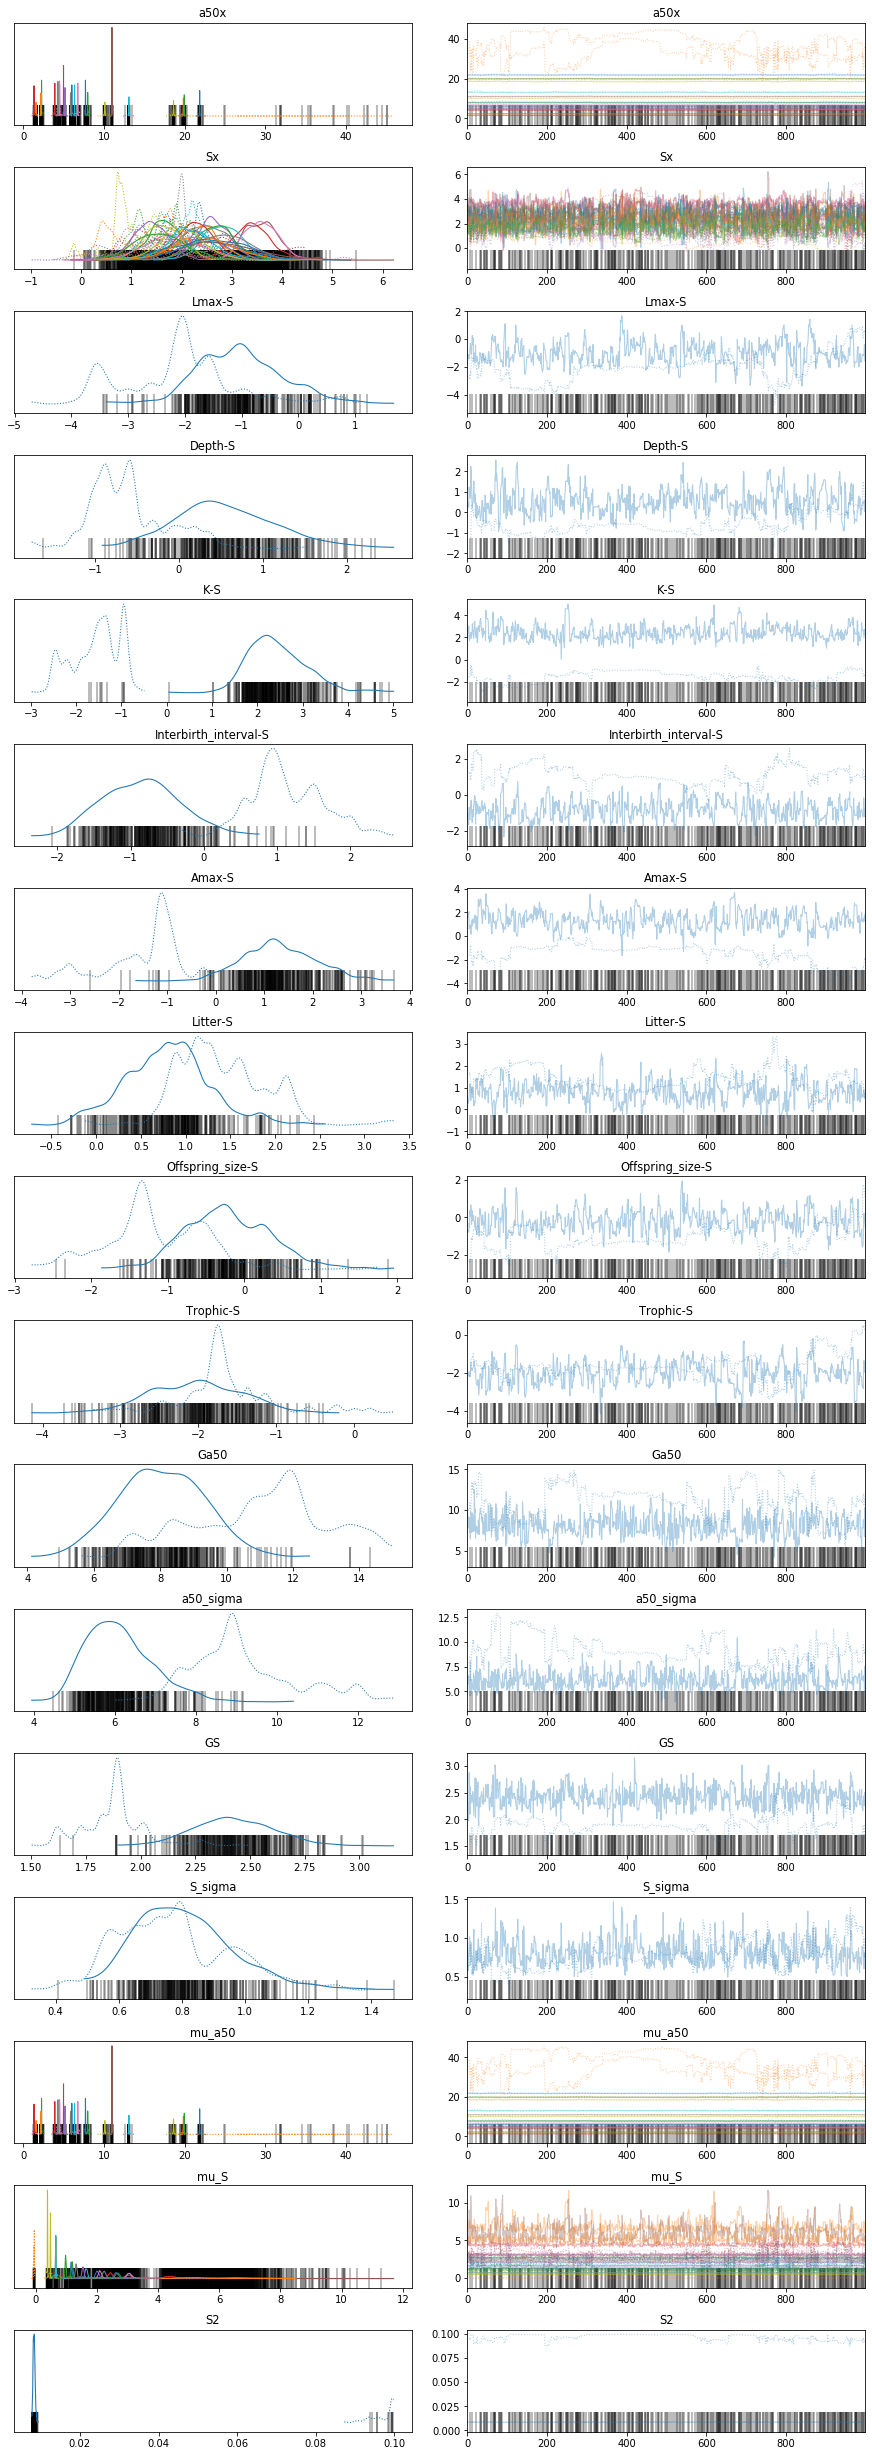

In [48]:
pm.traceplot(trace9)

In [49]:
pm.summary(trace9)
# looking for r-hat valeus of 1 - shows that model is converging

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
a50x[0]    6.004   0.103   5.790    6.182      0.012    0.008      78.0   
a50x[1]   16.821  15.552   1.524   38.548     10.772    9.045       2.0   
a50x[2]    2.296   0.114   2.063    2.506      0.021    0.015      29.0   
a50x[3]    1.365   0.096   1.223    1.607      0.022    0.017      18.0   
a50x[4]    4.539   0.095   4.400    4.800      0.029    0.021      11.0   
...          ...     ...     ...      ...        ...      ...       ...   
mu_S[19]   0.674   0.084   0.515    0.811      0.007    0.006     132.0   
mu_S[20]   2.457   0.374   1.417    2.899      0.104    0.075      13.0   
mu_S[21]   2.605   2.684  -0.090    5.856      1.873    1.578       2.0   
mu_S[22]   1.258   0.245   0.890    1.851      0.046    0.033      28.0   
S2         0.052   0.044   0.008    0.100      0.031    0.026       2.0   

          ess_sd  ess_bulk  ess_tail  r_hat  
a50x[0]     78.0      82.0      93.0   1.56  
a50x[1]      2.0       3.0      12.0   1.87  
a50x[2]     29.0      33.0      63.0   1.72  
a50x[3]     17.0      26.0      25.0   1.53  
a50x[4]     10.0      11.0      33.0   1.51  
...          ...       ...       ...    ...  
mu_S[19]   118.0     187.0     108.0   1.56  
mu_S[20]    13.0      16.0      38.0   1.39  
mu_S[21]     2.0       3.0      47.0   1.87  
mu_S[22]    28.0      53.0      81.0   1.46  
S2           2.0       3.0      61.0   1.88  

[105 rows x 11 columns]

### Compare Model Results

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


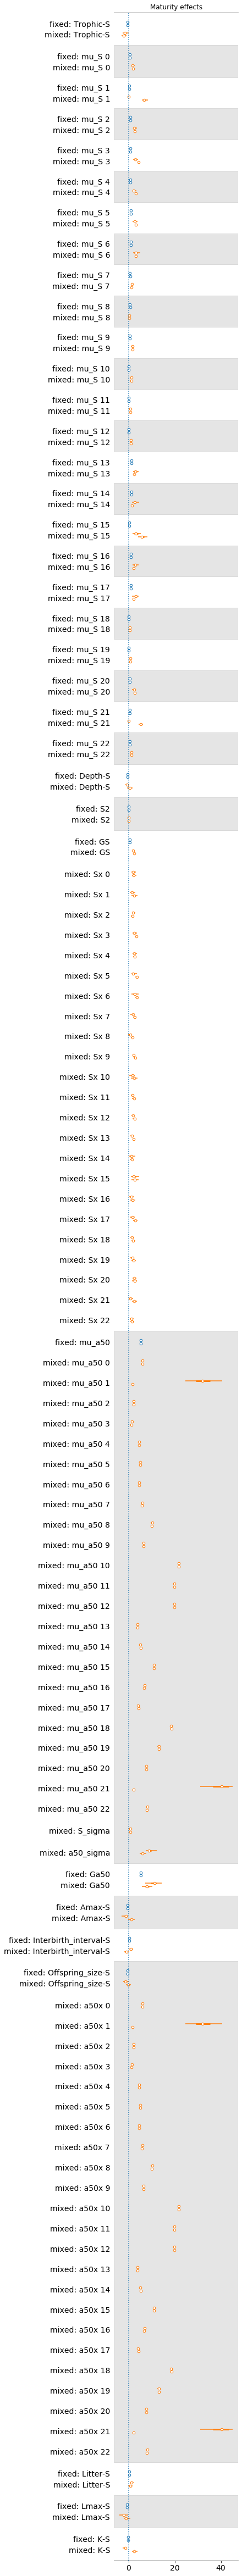

<Figure size 432x288 with 0 Axes>

In [52]:
# Forest plot to see size and direction of cov effects
# Compare mat 7 & 9 - mixed vs fixed effect for s covs only
# az.style.use("arviz-darkgrid")
axes = az.plot_forest(
    [trace7, trace9], model_names=["fixed", "mixed"])
axes[0].set_title("Maturity effects")
plt.axvline(0, linestyle=':')
plt.show()

#save figure
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Data\\for model\\out')
plt.savefig('mat7&9_forest.jpg');

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


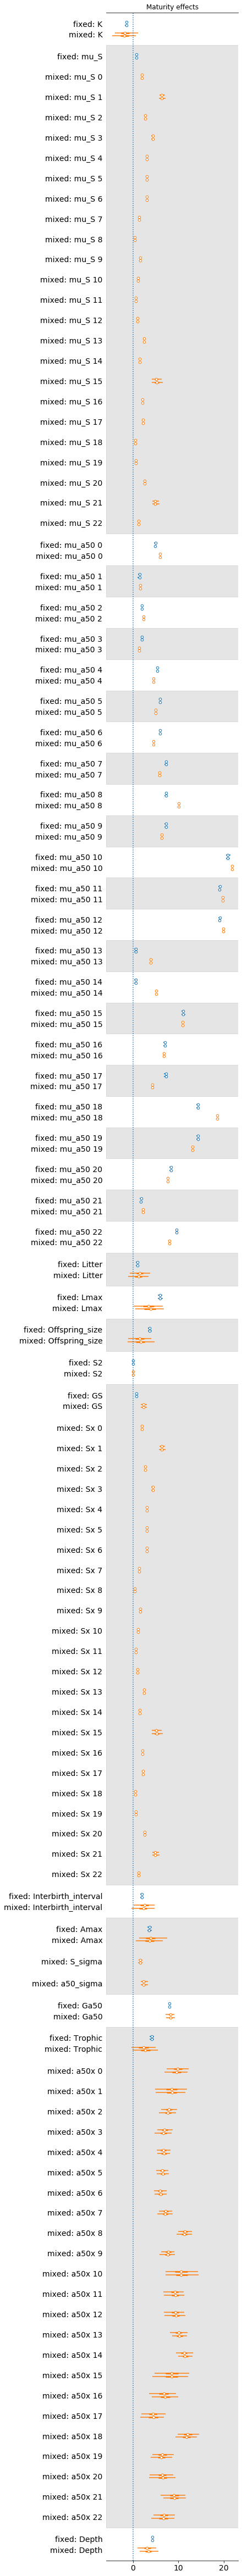

<Figure size 432x288 with 0 Axes>

In [53]:
# Forest plot to see size and direction of cov effects
# Compare mat 6 & 8 - mixed vs fixed effect for a50 covs only
# az.style.use("arviz-darkgrid")
axes = az.plot_forest(
    [trace6, trace8], model_names=["fixed", "mixed"])
axes[0].set_title("Maturity effects")
plt.axvline(0, linestyle=':')
plt.show()

#save figure
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Data\\for model\\out')
plt.savefig('mat6&8_forest.jpg');

### Model Performance Comparison

In [54]:
#WAIC for model 6 fixed effect a50
pm.waic(trace6, scale='deviance')

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:1427: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 2000 by 505 log-likelihood matrix

              Estimate       SE
deviance_waic   116.27   199.72
p_waic          109.30        -

There has been a warning during the calculation. Please check the results.

In [55]:
#WAIC for model 7 fixed effect s
pm.waic(trace7, scale='deviance')

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:1427: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 2000 by 505 log-likelihood matrix

              Estimate       SE
deviance_waic  3307.25   305.36
p_waic           72.75        -

There has been a warning during the calculation. Please check the results.

In [56]:
#WAIC for model 8 mixed effect a50
pm.waic(trace8, scale='deviance')

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:1427: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 2000 by 505 log-likelihood matrix

              Estimate       SE
deviance_waic -3289.31   126.54
p_waic           89.80        -

There has been a warning during the calculation. Please check the results.

In [57]:
#WAIC for model 9 mixed effect s
pm.waic(trace9, scale='deviance')

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:1427: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 2000 by 505 log-likelihood matrix

              Estimate       SE
deviance_waic  3218.96  1803.25
p_waic         3161.45        -

There has been a warning during the calculation. Please check the results.

#### Look for bad datapoints

In [58]:
loo6 = pm.loo(trace6, mat6)
loo6

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:684: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 2000 by 505 log-likelihood matrix

         Estimate       SE
elpd_loo   -57.82    99.53
p_loo      108.99        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      482   95.4%
 (0.5, 0.7]   (ok)         15    3.0%
   (0.7, 1]   (bad)         8    1.6%
   (1, Inf)   (very bad)    0    0.0%

In [59]:
loo7 = pm.loo(trace7,mat7)
loo7

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:684: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 2000 by 505 log-likelihood matrix

         Estimate       SE
elpd_loo -1653.47   152.65
p_loo       72.59        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      495   98.0%
 (0.5, 0.7]   (ok)          8    1.6%
   (0.7, 1]   (bad)         2    0.4%
   (1, Inf)   (very bad)    0    0.0%

In [61]:
loo8 = pm.loo(trace8, mat8)
loo8

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:684: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 2000 by 505 log-likelihood matrix

         Estimate       SE
elpd_loo  1636.76    62.86
p_loo       97.69        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      461   91.3%
 (0.5, 0.7]   (ok)         11    2.2%
   (0.7, 1]   (bad)        23    4.6%
   (1, Inf)   (very bad)   10    2.0%

In [62]:
loo9 = pm.loo(trace9, mat9)
loo9

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:684: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 2000 by 505 log-likelihood matrix

         Estimate       SE
elpd_loo   542.56   111.06
p_loo     1009.41        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      444   87.9%
 (0.5, 0.7]   (ok)         26    5.1%
   (0.7, 1]   (bad)        15    3.0%
   (1, Inf)   (very bad)   20    4.0%

In [63]:
# save bad points
bad6 = mdata.iloc[loo6.pareto_k.values > 0.7]
bad7 = mdata.iloc[loo7.pareto_k.values > 0.7]
bad8 = mdata.iloc[loo8.pareto_k.values > 0.7]
bad9 = mdata.iloc[loo9.pareto_k.values > 0.7]

### Plot Model Fits

In [67]:
# Save results to external file - mat6 fixed a50 only
result6 = pm.backends.tracetab.trace_to_dataframe(trace6)

# Edit column names
colnames = np.array(list(result6.columns), dtype=object)

colnames[np.array([list(colnames).index(x) for x in grep('mu_a50',colnames)])] = np.array(['a50_'+str(s) for s in StockYr])
#colnames[np.array([list(colnames).index(x) for x in grep('Sx',colnames)])] = np.array(['S_'+str(s) for s in StockYr])

result6.columns = list(colnames)

# each model run produces an a50 and S value for each stock-year
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Data\\for model\\out')
result6.to_csv('mat6_model_results.csv')
result6.head()

Lmax     Depth         K  Interbirth_interval      Amax    Litter  \
0  5.504195  4.248556 -1.542201             2.073654  3.527894  1.087774   
1  5.798210  4.055569 -1.574262             1.913960  3.688267  1.249164   
2  5.456532  4.582797 -1.501991             2.082691  3.975248  0.961274   
3  6.046934  4.235370 -1.436884             2.133682  3.228151  0.806456   
4  5.617992  4.421093 -1.696291             2.238712  3.507584  1.035519   

   Offspring_size   Trophic      Ga50        GS  ...  a50_GRE-SWP-06  \
0        3.457941  3.878283  7.969148  0.905333  ...       11.218846   
1        3.439836  3.702997  8.142339  0.814247  ...       11.189843   
2        3.758572  4.150597  7.911321  0.781924  ...       11.327837   
3        3.518206  4.169442  8.061027  0.816073  ...       11.116304   
4        3.713756  4.161029  8.059203  0.761920  ...       11.342849   

   a50_NER-I-02  a50_OCW-WCP-12  a50_SAN-NWA-06  a50_SAN-NWA-11  \
0      7.141571        7.254610       14.272562       14.272562   
1      7.292413        7.719465       14.365857       14.365857   
2      6.894262        6.678351       14.626211       14.626211   
3      6.995955        7.544596       14.339043       14.339043   
4      7.186974        7.184001       14.525799       14.525799   

   a50_SPIN-WP-05  a50_SPT-SWP-13  a50_WTIP-SWP-06      mu_S        S2  
0        8.266793        1.757702         9.661916  0.905333  0.099862  
1        8.851225        1.981351         9.764362  0.814247  0.099792  
2        7.904365        1.679231         9.934834  0.781924  0.099974  
3        8.549934        1.702707         9.598165  0.816073  0.099816  
4        8.123663        1.633563         9.935629  0.761920  0.099884  

[5 rows x 35 columns]

In [69]:
# Save results to external file - mat7 fixed s only
result7 = pm.backends.tracetab.trace_to_dataframe(trace7)

# Edit column names
colnames = np.array(list(result7.columns), dtype=object)

#colnames[np.array([list(colnames).index(x) for x in grep('mu_a50',colnames)])] = np.array(['a50_'+str(s) for s in StockYr])
colnames[np.array([list(colnames).index(x) for x in grep('mu_S',colnames)])] = np.array(['S_'+str(s) for s in StockYr])

result7.columns = list(colnames)

# each model run produces an a50 and S value for each stock-year
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Data\\for model\\out')
result7.to_csv('mat7_model_results.csv')
result7.head()

Lmax-S   Depth-S       K-S  Interbirth_interval-S    Amax-S  Litter-S  \
0 -0.863655 -0.579956 -0.287700               0.281954 -0.159899  0.297382   
1 -0.468869 -0.469891 -0.253258               0.276363 -0.488142  0.211138   
2 -0.492848 -0.466172 -0.248992               0.223277 -0.408621  0.149717   
3 -0.550632 -0.445166 -0.314315               0.292071 -0.446146  0.159746   
4 -0.484004 -0.462715 -0.337639               0.235038 -0.521376  0.203797   

   Offspring_size-S  Trophic-S      Ga50        GS  ...  S_FTH-NWA-07  \
0         -0.297594  -0.581569  5.308320  0.623163  ...      1.338317   
1         -0.325840  -0.328563  5.165861  0.538247  ...      1.192326   
2         -0.197185  -0.311731  5.217059  0.603293  ...      1.252516   
3         -0.177073  -0.301796  5.244833  0.595295  ...      1.263184   
4         -0.313958  -0.369525  5.429704  0.575886  ...      1.255877   

   S_GRE-SWP-06  S_NER-I-02  S_OCW-WCP-12  S_SAN-NWA-06  S_SAN-NWA-11  \
0      0.166833    1.089592      0.767713      0.068978      0.068978   
1      0.166542    0.991877      0.875912      0.066180      0.066180   
2      0.179413    0.946783      0.817294      0.069860      0.069860   
3      0.201353    0.958059      0.794696      0.067205      0.067205   
4      0.227452    0.956166      0.958820      0.076695      0.076695   

   S_SPIN-WP-05  S_SPT-SWP-13  S_WTIP-SWP-06        S2  
0      0.576236      0.747578       0.705605  0.099992  
1      0.555459      0.431957       0.365710  0.099991  
2      0.538256      0.669119       0.574132  0.099970  
3      0.461469      0.607626       0.617186  0.099986  
4      0.589322      0.515124       0.475604  0.099974  

[5 rows x 35 columns]

In [72]:
# Save results to external file - mat8 mixed a50 only
result8 = pm.backends.tracetab.trace_to_dataframe(trace8)

# Edit column names
colnames = np.array(list(result8.columns), dtype=object)

colnames[np.array([list(colnames).index(x) for x in grep('a50x',colnames)])] = np.array(['a50_'+str(s) for s in StockYr])
colnames[np.array([list(colnames).index(x) for x in grep('mu_S',colnames)])] = np.array(['S_'+str(s) for s in StockYr])

result8.columns = list(colnames)

# each model run produces an a50 and S value for each stock-year
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Data\\for model\\out')
result8.to_csv('mat8_model_results.csv')
result8.head()

a50_ABTP-SWP-13  a50_ATSH-GOM-03  a50_ATSH-NWA-07  a50_ATSH-NWA-13  \
0        10.087120         8.743273         7.966748         7.036446   
1        10.762470         8.049317         7.087158         6.135028   
2         9.990708         8.423055         6.914165         5.927908   
3         8.984924         8.152414         7.266415         6.370074   
4         6.616625         9.421650         6.887020         5.888932   

   a50_BNOS-GOM-11  a50_BNOS-NWA-07  a50_BNOS-NWA-11  a50_BTIP-GOM-05  \
0         5.597576         5.459984         4.947249         5.663229   
1         5.420634         5.398037         4.910472         6.288377   
2         6.153060         5.918367         5.411603         5.897037   
3         6.737694         6.412770         5.938036         7.636278   
4         7.806702         7.018105         6.548422         7.058506   

   a50_BTIP-GOM-12  a50_BTIP-NWA-06  ...  S_FTH-NWA-07  S_GRE-SWP-06  \
0         9.853804         6.170932  ...      1.570800      4.617030   
1        10.543170         6.811747  ...      1.573322      5.393008   
2        10.168262         6.480482  ...      1.550583      6.653035   
3        11.888249         8.224284  ...      1.514587      4.894541   
4        11.277287         7.661034  ...      1.570091      5.039898   

   S_NER-I-02  S_OCW-WCP-12  S_SAN-NWA-06  S_SAN-NWA-11  S_SPIN-WP-05  \
0    2.212703      2.174482      0.494071      0.655046      2.645031   
1    2.094304      2.362028      0.481435      0.646226      2.512335   
2    2.075283      2.306686      0.493099      0.657984      2.782944   
3    2.172768      2.191185      0.476937      0.659032      2.614777   
4    2.055018      2.216623      0.488156      0.644720      2.558326   

   S_SPT-SWP-13  S_WTIP-SWP-06        S2  
0      4.685446       1.175145  0.008313  
1      4.679562       1.204817  0.008290  
2      4.386980       1.207455  0.008909  
3      5.035547       1.187959  0.008474  
4      5.301790       1.218196  0.009055  

[5 rows x 105 columns]

In [74]:
# Save results to external file - mat9 mixed s only
result9 = pm.backends.tracetab.trace_to_dataframe(trace9)

# Edit column names
colnames = np.array(list(result9.columns), dtype=object)

colnames[np.array([list(colnames).index(x) for x in grep('a50x',colnames)])] = np.array(['a50_'+str(s) for s in StockYr])
colnames[np.array([list(colnames).index(x) for x in grep('mu_S',colnames)])] = np.array(['S_'+str(s) for s in StockYr])

result9.columns = list(colnames)

# each model run produces an a50 and S value for each stock-year
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Data\\for model\\out')
result9.to_csv('mat9_model_results.csv')
result9.head()

a50_ABTP-SWP-13  a50_ATSH-GOM-03  a50_ATSH-NWA-07  a50_ATSH-NWA-13  \
0         6.018657         1.607150         2.268727         1.354329   
1         6.027794         1.624870         2.267109         1.343444   
2         6.048692         1.615770         2.269822         1.320280   
3         6.032554         1.623058         2.275662         1.322067   
4         6.044266         1.588674         2.287823         1.321239   

   a50_BNOS-GOM-11  a50_BNOS-NWA-07  a50_BNOS-NWA-11  a50_BTIP-GOM-05  \
0         4.502273         4.983256         4.509992         5.882457   
1         4.497702         4.987982         4.504997         5.891787   
2         4.508173         5.000417         4.504829         5.881930   
3         4.510244         4.997822         4.499762         5.899808   
4         4.516974         5.000180         4.518415         5.895336   

   a50_BTIP-GOM-12  a50_BTIP-NWA-06  ...  S_FTH-NWA-07  S_GRE-SWP-06  \
0        10.114692         6.359211  ...      1.523447      5.202496   
1        10.083224         6.361491  ...      1.531796      4.585289   
2        10.060368         6.388660  ...      1.569226      5.917528   
3        10.108321         6.385641  ...      1.582846      4.876416   
4        10.060275         6.389219  ...      1.558338      4.212845   

   S_NER-I-02  S_OCW-WCP-12  S_SAN-NWA-06  S_SAN-NWA-11  S_SPIN-WP-05  \
0    1.983892      2.193611      0.490833      0.671208      2.665100   
1    2.150515      2.334621      0.477225      0.670217      2.705116   
2    2.006756      2.263785      0.482230      0.674833      2.678510   
3    2.068926      2.149431      0.480105      0.641849      2.682575   
4    2.078648      2.159448      0.471628      0.675638      2.615009   

   S_SPT-SWP-13  S_WTIP-SWP-06        S2  
0      5.471860       1.199196  0.008223  
1      4.938984       1.171563  0.008336  
2      5.452200       1.185684  0.008572  
3      5.184836       1.208406  0.008531  
4      5.235264       1.209668  0.008423  

[5 rows x 105 columns]

In [96]:
# Grab data from mat6 results
# Grab a50's
# take median mu_a50 value for each stock-year to visualise effect of covs on a50
#μa50s2 = np.array([np.median(result2[x]) for x in np.array(['a50_'+str(s) for s in list(range(len(StockYr)))])]).T
a50s6 = np.array([np.median(result6[x]) for x in np.array(['a50_'+str(s) for s in StockYr])]).T

# Grab S's
#Ss6 = np.array([np.median(result6[x]) for x in np.array(['S_'+str(s) for s in StockYr])]).T
Ss6 = np.median(result6.GS)
Ss6 = [Ss6]*nstocks

# xrange
# Make a vector of ages from 0 to max age
xr = np.linspace(0,max(AGE),max(AGE).astype(int)+1)

In [100]:
# Grab data from mat7 results
# Grab a50's
# take median mu_a50 value for each stock-year to visualise effect of covs on a50
a50s7 = np.median(result7.mu_a50)
a50s7 = [a50s7]*nstocks

# Grab S's
Ss7 = np.array([np.median(result7[x]) for x in np.array(['S_'+str(s) for s in StockYr])]).T

# xrange
# Make a vector of ages from 0 to max age
xr = np.linspace(0,max(AGE),max(AGE).astype(int)+1)

In [101]:
# Grab data from mat8 results
# Grab a50's
# take median mu_a50 value for each stock-year to visualise effect of covs on a50
μa50s8 = np.array([np.median(result8[x]) for x in np.array(['mu_a50__'+str(s) for s in list(range(len(StockYr)))])]).T

# can also just look at a50s
#a50s = np.array([np.median(result8[x]) for x in np.array(['a50_'+str(s) for s in StockYr])]).T

# Grab S's
μSs8 = np.array([np.median(result8[x]) for x in np.array(['Sx__'+str(s) for s in list(range(len(StockYr)))])]).T
Ss8 = np.array([np.median(result8[x]) for x in np.array(['S_'+str(s) for s in StockYr])]).T

# xrange
xr = np.linspace(0,max(AGE),max(AGE).astype(int)+1)

In [102]:
# Grab data from mat9 results
# Grab a50's
# take median mu_a50 value for each stock-year to visualise effect of covs on a50
μa50s9 = np.array([np.median(result9[x]) for x in np.array(['mu_a50__'+str(s) for s in list(range(len(StockYr)))])]).T

# can also just look at a50s
a50s9 = np.array([np.median(result9[x]) for x in np.array(['a50_'+str(s) for s in StockYr])]).T

# Grab S's
μSs9 = np.array([np.median(result9[x]) for x in np.array(['Sx__'+str(s) for s in list(range(len(StockYr)))])]).T
Ss9 = np.array([np.median(result9[x]) for x in np.array(['S_'+str(s) for s in StockYr])]).T

# xrange
xr = np.linspace(0,max(AGE),max(AGE).astype(int)+1)

#### Visualise a50 models

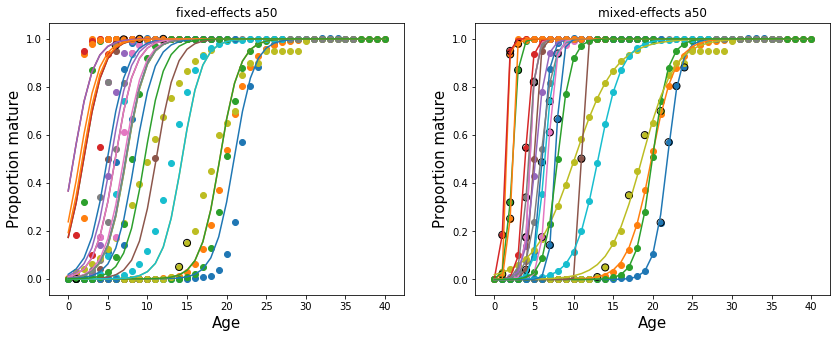

In [105]:
#set up figure
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14,5))
ax_ = axes.flatten()

#Plot mat6 fixed effect
#scatter plot of mat and age data
[ax_[0].scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
# add markers for points with bad pareto k scores
ax_[0].scatter(bad6.Age, bad6.maturity, facecolors='none', edgecolors='k', s=50)
#plot ogives with median S and mu_a50 values
[ax_[0].plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(Ss6, a50s6)]
#make plot pretty
ax_[0].set_xlabel('Age',fontsize=15)
ax_[0].set_ylabel('Proportion mature',fontsize=15)
ax_[0].set_title('fixed-effects a50')

#Plot mat8 mixed effect
#scatter plot of mat and age data
[ax_[1].scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
# add markers for poitns with high pareto k scores
ax_[1].scatter(bad8.Age, bad8.maturity, facecolors='none', edgecolors='k', s=50)
#plot ogives with median S and mu_a50 values
[ax_[1].plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(μSs8, μa50s8)]
#make plot pretty
ax_[1].set_xlabel('Age',fontsize=15)
ax_[1].set_ylabel('Proportion mature',fontsize=15)
ax_[1].set_title('mixed-effects a50')

#save results
plt.savefig('mat6_mat8_modelfit.jpg',dpi=300);

#### Visualise s models

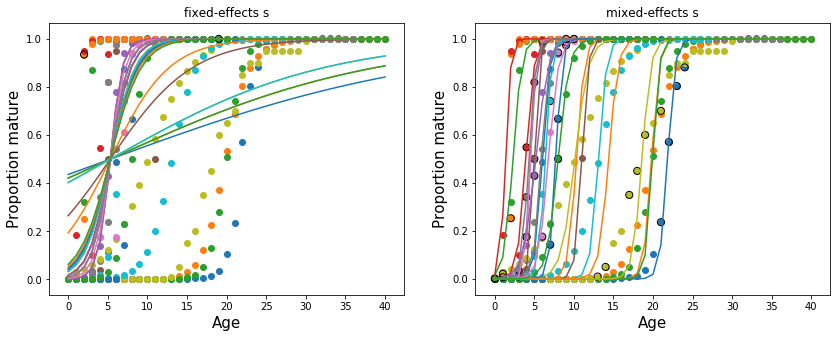

In [106]:
#set up figure
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14,5))
ax_ = axes.flatten()

#Plot mat7 fixed effect
#scatter plot of mat and age data
[ax_[0].scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
# add markers for points with bad pareto k scores
ax_[0].scatter(bad7.Age, bad7.maturity, facecolors='none', edgecolors='k', s=50)
#plot ogives with median S and mu_a50 values
[ax_[0].plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(Ss7, a50s7)]
#make plot pretty
ax_[0].set_xlabel('Age',fontsize=15)
ax_[0].set_ylabel('Proportion mature',fontsize=15)
ax_[0].set_title('fixed-effects s')

#Plot mat9 mixed effect
#scatter plot of mat and age data
[ax_[1].scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
# add markers for poitns with high pareto k scores
ax_[1].scatter(bad9.Age, bad9.maturity, facecolors='none', edgecolors='k', s=50)
#plot ogives with median S and mu_a50 values
[ax_[1].plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(μSs9, μa50s9)]
#make plot pretty
ax_[1].set_xlabel('Age',fontsize=15)
ax_[1].set_ylabel('Proportion mature',fontsize=15)
ax_[1].set_title('mixed-effects s')

#save results
plt.savefig('mat7_mat9_modelfit.jpg',dpi=300);